# Intrinsic Evaluation

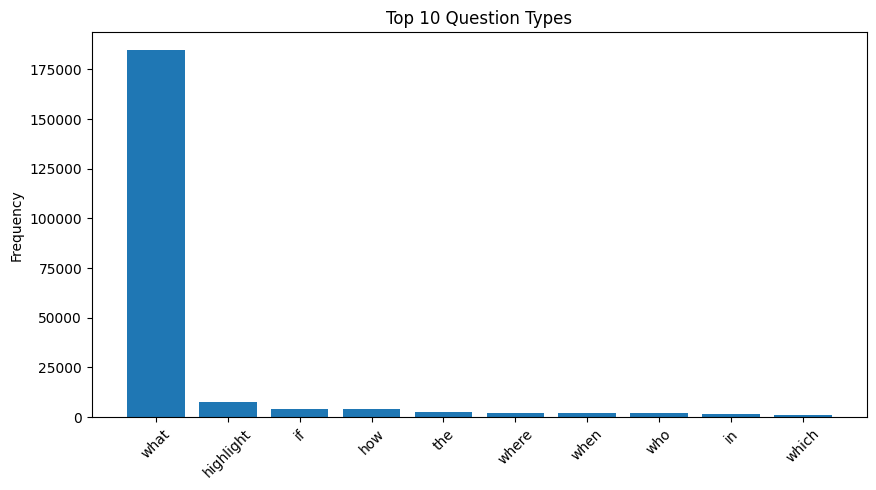

=== Intrinsic QA Evaluation Summary ===
                            Metric       Value
0                   Total QA Pairs  218347.000
1            Answer in Context (%)     100.000
2             Unique Questions (%)      71.880
3               Unique Answers (%)      51.660
4  Avg. Answer Position in Context       0.267
5    Avg. Answer Span % of Context       0.034


In [1]:
import json, re
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def normalize(t): 
    return re.sub(r"\s+", " ", t.strip().lower())

qa_path = Path("/mnt/data/QA Generation Pipeline results/3gpp_testing.jsonl")
qa_data = [json.loads(line) for line in qa_path.open("r", encoding="utf-8")]

# Parse ### Context / ### Question / ### Answer from the "text" field
PAT = re.compile(
    r"### Context:\s*(.*?)\s*### Question:\s*(?:question:\s*)?(.*?)\s*### Answer:\s*\[/INST\]\s*(.*?)\s*(?:</s>|$)",
    re.DOTALL | re.IGNORECASE
)

total_pairs = len(qa_data)
answer_in_context_count = 0
unique_questions, unique_answers = set(), set()
question_types, answer_positions, answer_spans = [], [], []
context_lengths, answer_lengths = [], []

for item in qa_data:
    context = question = answer = ""

    if "input" in item or "output" in item:
        raw_input = item.get("input", "")
        answer = item.get("output", "").strip()
        m = re.search(r"### Context:\s*(.*?)\s*### Question:\s*(?:question:\s*)?(.*)", raw_input, re.DOTALL|re.IGNORECASE)
        if m:
            context, question = m.groups()
    else:
        text = item.get("text", "")
        m = PAT.search(text)
        if m:
            context, question, answer = [s.strip() for s in m.groups()]

    # metrics
    norm_context, norm_answer = normalize(context), normalize(answer)
    if norm_answer and norm_answer in norm_context:
        answer_in_context_count += 1
        idx = norm_context.find(norm_answer)
        if idx >= 0 and len(norm_context) > 0:
            answer_positions.append(idx / len(norm_context))
            answer_spans.append(len(norm_answer) / len(norm_context))

    if question:
        if question.lower().startswith("question:"):
            question = question[len("question:"):].strip()
        fw = re.split(r"[^\w]+", question.strip())
        if fw and fw[0]:
            question_types.append(fw[0].lower())
        unique_questions.add(question)

    if answer:
        unique_answers.add(answer)

    context_lengths.append(len(context.split()))
    answer_lengths.append(len(answer.split()))

summary = pd.DataFrame({
    "Metric": [
        "Total QA Pairs",
        "Answer in Context (%)",
        "Unique Questions (%)",
        "Unique Answers (%)",
        "Avg. Answer Position in Context",
        "Avg. Answer Span % of Context"
    ],
    "Value": [
        total_pairs,
        round(answer_in_context_count / total_pairs * 100, 2),
        round(len(unique_questions) / total_pairs * 100, 2),
        round(len(unique_answers) / total_pairs * 100, 2),
        round(pd.Series(answer_positions).mean(), 3) if answer_positions else None,
        round(pd.Series(answer_spans).mean(), 3) if answer_spans else None
    ]
})

qt_counts = Counter(question_types)
if qt_counts:
    qt_df = (pd.DataFrame(qt_counts.items(), columns=["Question Type","Count"])
             .sort_values("Count", ascending=False))
    plt.figure(figsize=(10,5))
    plt.bar(qt_df["Question Type"][:10], qt_df["Count"][:10])
    plt.title("Top 10 Question Types")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No question types parsed.")

print("=== Intrinsic QA Evaluation Summary ===")
print(summary)

# Semantic Redundancy Detection Using FAISS + SBERT

In [2]:
from sentence_transformers import SentenceTransformer
import faiss, numpy as np, json, re
from pathlib import Path
from tqdm import tqdm

qa_path = Path("/mnt/data/QA Generation Pipeline results/3gpp_testing.jsonl")

PAT = re.compile(
    r"### Context:\s*(.*?)\s*### Question:\s*(?:question:\s*)?(.*?)\s*### Answer:\s*\[/INST\]\s*(.*?)\s*(?:</s>|$)",
    re.DOTALL | re.IGNORECASE
)

def extract_question_from_text(text):
    m = PAT.search(text)
    return (m.group(2).strip() if m else "").replace("\n", " ")

# 1) Collect questions
questions = []
with qa_path.open("r", encoding="utf-8") as f:
    for line in f:
        d = json.loads(line)
        questions.append(extract_question_from_text(d.get("text","")))

# 2) Encode
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(questions, convert_to_numpy=True, batch_size=512, show_progress_bar=True)

# 3) Normalize for cosine and build FAISS index
faiss.normalize_L2(emb)
index = faiss.IndexFlatIP(emb.shape[1])
index.add(emb)

# 4) Search top-2 (self + nearest neighbor)
D, I = index.search(emb, k=2)

# 5) Record redundant pairs above threshold
threshold = 0.92  # tune
pairs = set()
redundant = []
for i in range(len(questions)):
    j = int(I[i,1])
    score = float(D[i,1])
    if score >= threshold:
        key = (min(i,j), max(i,j))
        if key not in pairs:
            pairs.add(key)
            redundant.append((i, j, score))

print("\n=== Semantic Redundancy (FAISS) ===")
print(f"Total QA pairs: {len(questions)}")
print(f"Highly similar (cosine >= {threshold}): {len(redundant)}")
print(f"Redundancy rate: {len(redundant) / max(len(questions),1) * 100:.2f}%")

print("\n=== Top 10 Most Similar Question Pairs ===")
for i, (a,b,s) in enumerate(sorted(redundant, key=lambda x: -x[2])[:10], 1):
    print(f"[{i:02}] {s:.3f} :: Q{a}: {questions[a]}\n               Q{b}: {questions[b]}\n")

KeyError: 'input'

# Model-Based QA Answer Accuracy (EM & F1)

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
from tqdm import tqdm
import json, re
from pathlib import Path
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

qa_path = Path("/mnt/data/QA Generation Pipeline results/3gpp_testing.jsonl")
PAT = re.compile(
    r"### Context:\s*(.*?)\s*### Question:\s*(?:question:\s*)?(.*?)\s*### Answer:\s*\[/INST\]\s*(.*?)\s*(?:</s>|$)",
    re.DOTALL | re.IGNORECASE
)

def parse_triple(text):
    m = PAT.search(text)
    return (m.group(1).strip(), m.group(2).strip(), m.group(3).strip()) if m else ("","","")

rows = []
with qa_path.open("r", encoding="utf-8") as f:
    for line in f:
        d = json.loads(line)
        ctx,q,ans = parse_triple(d.get("text",""))
        if ctx and q and ans:
            rows.append({"context":ctx, "question":q, "gold_answer":ans})
data_df = pd.DataFrame(rows)

# Load trained model
model_path = "/home/ec2-user/qa_roberta_telecom"
qa = pipeline(
    "question-answering",
    model=AutoModelForQuestionAnswering.from_pretrained(model_path),
    tokenizer=AutoTokenizer.from_pretrained(model_path),
    device=0  # set -1 for CPU
)

# Predict
predicted = []
for _, r in tqdm(data_df.iterrows(), total=len(data_df)):
    out = qa({"question": r["question"], "context": r["context"]})
    predicted.append(out.get("answer",""))

# SQuAD-style EM/F1
from collections import Counter
def normalize_space(s): return re.sub(r"\s+", " ", s.strip().lower())

def f1_score(pred, gold):
    ptoks = normalize_space(pred).split()
    gtoks = normalize_space(gold).split()
    if len(ptoks)==0 and len(gtoks)==0: return 1.0
    if len(ptoks)==0 or len(gtoks)==0:  return 0.0
    common = sum((Counter(ptoks) & Counter(gtoks)).values())
    if common == 0: return 0.0
    prec = common / len(ptoks)
    rec  = common / len(gtoks)
    return 2*prec*rec/(prec+rec)

data_df["predicted_answer"] = predicted
data_df["em"] = (data_df["predicted_answer"].map(normalize_space) == data_df["gold_answer"].map(normalize_space)).astype(int)
data_df["f1"] = [f1_score(p,g) for p,g in zip(data_df["predicted_answer"], data_df["gold_answer"])]

print("\n=== Batch QA Evaluation Results ===")
print(f"Total evaluated: {len(data_df)}")
print(f"Exact Match (EM): {data_df['em'].mean():.4f}")
print(f"F1 Score:          {data_df['f1'].mean():.4f}")

# Save for downstream plots
data_df.to_csv("qa_eval_results.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert evaluation results to DataFrame
eval_df = pd.DataFrame({
    "question": [i["question"] for i in inputs],
    "context": [i["context"] for i in inputs],
    "gold_answer": gold_answers,
    "predicted_answer": [p["answer"] for p in predictions],
    "f1": f1_scores,
    "em": em_scores
})

# save to file for future analysis
eval_df.to_csv("qa_eval_results.csv", index=False)

# Plot F1 Score distribution
plt.figure(figsize=(8, 4))
plt.hist(eval_df["f1"], bins=20, range=(0, 1), color='skyblue', edgecolor='black')
plt.title("F1 Score Distribution")
plt.xlabel("F1 Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Plot Exact Match (EM) distribution
plt.figure(figsize=(6, 3))
plt.bar(["Mismatch (0)", "Exact Match (1)"], eval_df["em"].value_counts().sort_index(), color=["salmon", "lightgreen"])
plt.title("Exact Match (EM) Distribution")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()

In [ ]:
# Add a new column: length of predicted answer
eval_df["predicted_len"] = eval_df["predicted_answer"].apply(lambda x: len(x.split()))

# Scatter plot: Predicted Answer Length vs F1 Score
plt.figure(figsize=(8, 4))
plt.scatter(eval_df["predicted_len"], eval_df["f1"], alpha=0.3, color='purple')
plt.title("Predicted Answer Length vs F1 Score")
plt.xlabel("Predicted Answer Length (words)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [ ]:
# Normalized position of gold answer in context
def get_answer_pos(row):
    try:
        return row["context"].find(row["gold_answer"]) / len(row["context"])
    except:
        return None

eval_df["gold_pos"] = eval_df.apply(get_answer_pos, axis=1)

# Scatter: Position vs F1
plt.figure(figsize=(8, 4))
plt.scatter(eval_df["gold_pos"], eval_df["f1"], alpha=0.3, color='teal')
plt.title("Gold Answer Start Position (normalized) vs F1 Score")
plt.xlabel("Gold Answer Position (0 = start, 1 = end)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

# Correlation coefficient
corr = eval_df[["gold_pos", "f1"]].corr().iloc[0, 1]
print(f"Pearson correlation between answer position and F1 score: {corr:.3f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select one mismatched example for visualization
sample = eval_df[eval_df["f1"] < 0.5].sample(1).iloc[0]

pred_tokens = sample["predicted_answer"].lower().split()
gold_tokens = sample["gold_answer"].lower().split()

# Create token overlap matrix
overlap = np.zeros((len(gold_tokens), len(pred_tokens)))
for i, gt in enumerate(gold_tokens):
    for j, pt in enumerate(pred_tokens):
        overlap[i, j] = int(gt == pt)

# Plot heatmap
plt.figure(figsize=(len(pred_tokens) * 0.8, len(gold_tokens) * 0.8))
sns.heatmap(overlap, annot=True, cbar=False, xticklabels=pred_tokens, yticklabels=gold_tokens, cmap="Greens")
plt.title("Token Match Heatmap (Gold vs Predicted)")
plt.xlabel("Predicted Tokens")
plt.ylabel("Gold Tokens")
plt.show()

print(f"Context: {sample['context'][:300]}...")
print(f"Gold Answer: {sample['gold_answer']}")
print(f"Predicted:   {sample['predicted_answer']}")